<span style="color:red">This notebook is an adapted version from  </span>  http://pyro.ai/examples/bayesian_regression.html

## Setup
Let's begin by importing the modules we'll need.

In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta, Gamma, Binomial
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

# for CI testing
assert pyro.__version__.startswith('0.3.2')
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# Dataset 

The following example is taken from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
 
  
We will take the logarithm for the response variable GDP as it tends to vary exponentially. We also use a new variable `african_rugged`, defined as the product between the variables `rugged` and `cont_africa`, to capture the correlation between ruggedness and whether a country is in Africa.

In [2]:
DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df["african_rugged"] = data["cont_africa"] * data["rugged"]
df = df[["cont_africa", "rugged", "african_rugged", "rgdppc_2000"]]

In [3]:
# Display first 10 entries 
display(df[0:10])

,cont_africa,rugged,african_rugged,rgdppc_2000
2,1,0.858,0.858,7.492609
4,0,3.427,0.000,8.216929
7,0,0.769,0.000,9.933263
8,0,0.775,0.000,9.407032
9,0,2.688,0.000,7.792343
11,0,0.006,0.000,9.212541
12,0,0.143,0.000,10.143191
13,0,3.513,0.000,10.274632
14,0,1.672,0.000,7.852028
15,1,1.780,1.780,6.432380


# 1. Linear Regression

Regression is one of the most common and basic supervised learning tasks in machine learning. Suppose we're given a dataset $\mathcal{D}$ of the form

$$ \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

The goal of linear regression is to fit a function to the data of the form:

$$ y = w X + b + \epsilon $$

where $w$ and $b$ are learnable parameters and $\epsilon$ represents observation noise. Specifically $w$ is a matrix of weights and $b$ is a bias vector.

Let's first implement linear regression in PyTorch and learn point estimates for the parameters $w$ and $b$.  Then we'll see how to incorporate uncertainty into our estimates by using Pyro to implement Bayesian regression.

[Text(0,0.5,'log GDP (2000)'),
 Text(0.5,0,'Terrain Ruggedness Index'),
 Text(0.5,1,'African Nations')]

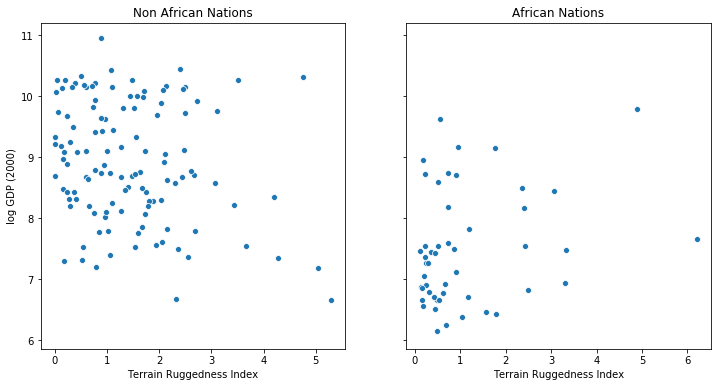

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = data[data["cont_africa"] == 1]
non_african_nations = data[data["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"], 
            np.log(non_african_nations["rgdppc_2000"]), 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"], 
            np.log(african_nations["rgdppc_2000"]), 
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

## 1.1 Model
We would like to predict log GDP per capita of a nation as a function of three features from the dataset - whether the nation is in Africa, its Terrain Ruggedness Index, and the interaction between these two.  Let's define our regression model. We'll define an specific object encapsulating this linear regression model.  Our input `x_data` is a tensor of size $N \times 3$ and our output `y_data` is a tensor of size $N \times 1$.  The method `predict(self,x_data)` defines a linear transformation of the form $Xw + b$ where $w$ is the weight matrix and $b$ is the additive bias.

The parameters of the model are defined using ``torch.nn.Parameter``, and will be learned during training. 

In [5]:
class RegressionModel():
    def __init__(self):
        self.w = torch.nn.Parameter(torch.zeros(1, 3))
        self.b = torch.nn.Parameter(torch.zeros(1, 1))

    def params(self):
        return {"b":self.b, "w": self.w}

    def predict(self, x_data):
        return (self.b + torch.mm(self.w, torch.t(x_data))).squeeze(0)

regression_model = RegressionModel()

## 1.2 Training
We will use the mean squared error (MSE) as our loss and Adam as our optimizer. We would like to optimize the parameters of the `regression_model` neural net above. We will use a somewhat large learning rate of `0.05` and run for 1000 iterations.

In [6]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(regression_model.params().values(), lr=0.05)
num_iterations = 5000
data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

def main():
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model.predict(x_data)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in regression_model.params().items():
        print(name, param.data.numpy())

main()

[iteration 0500] loss: 208.7966
[iteration 1000] loss: 147.9409
[iteration 1500] loss: 147.8815
[iteration 2000] loss: 147.8815
[iteration 2500] loss: 147.8815
[iteration 3000] loss: 147.8815
[iteration 3500] loss: 147.8815
[iteration 4000] loss: 147.8815
[iteration 4500] loss: 147.8815
[iteration 5000] loss: 147.8815
Learned parameters:
b [[9.223223]]
w [[-1.9480442  -0.2028555   0.39339212]]


## 1.3 Evaluating the model

We now plot the regression line learned for african and non-afrian nations relating the rugeedness index with the GDP of the country.

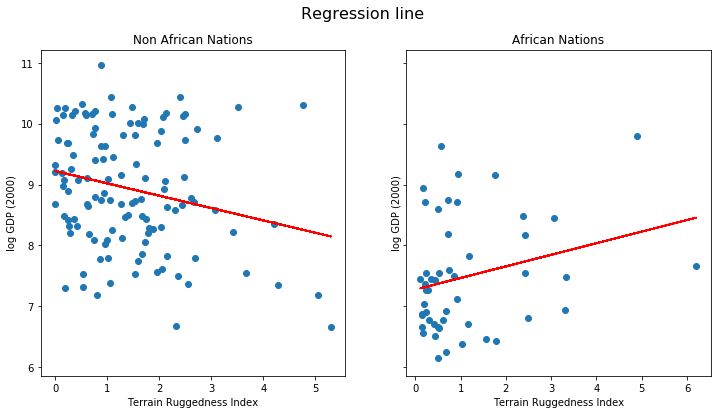

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Regression line ", fontsize=16)
ax[0].scatter(x_data[x_data[:,0]==0,1].detach().numpy(), y_data[x_data[:,0]==0].detach().numpy())
ax[1].scatter(x_data[x_data[:,0]==1,1].detach().numpy(), y_data[x_data[:,0]==1].detach().numpy())

for i in range(10):
    ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regression_model.predict(x_data[x_data[:,0]==0,:]).detach().numpy(), color='r')
    ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regression_model.predict(x_data[x_data[:,0]==1,:]).detach().numpy(), color='r')

ax[0].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="Non African Nations")
ax[1].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="African Nations")

plt.show()

## 1.4 The relationship between ruggedness and log GPD



Using this analysis, we can estimate the relationship between ruggedness and log GPD. As can be seen, this relationship is positive for African nations, but negative for Non African Nations.

In [8]:
slope_within_africa = regression_model.params()['w'][0,1] + regression_model.params()['w'][0,2]
slope_outside_africa = regression_model.params()['w'][0,1]
print(slope_within_africa)
print(slope_outside_africa)

tensor(0.1905, grad_fn=<AddBackward0>)
tensor(-0.2029, grad_fn=<SelectBackward>)


# 2. Bayesian Linear Regression


[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a _distribution_ over variables that are consistent with the observed data.

In order to make our linear regression Bayesian, we need to put priors on the parameters $w$, $b$ and $f$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).


## 2.1 Model

We now have all the ingredients needed to specify our model. First we define priors over weights and bias. Note the priors that we are using for the different latent variables in the model. The prior on the intercept parameter is very flat as we would like this to be learnt from the data. We are using a weakly regularizing prior on the regression coefficients to avoid overfitting to the data.

We use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise `sigma`.

In [9]:
def model(x_data, y_data):
    # weight and bias priors
    w = pyro.sample("w", Normal(torch.zeros(1, 3), torch.ones(1, 3)).to_event(1))
    b = pyro.sample("b", Normal(0., 1000.))

    precision = pyro.sample("precision", Gamma(1., 1.))
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = (b + torch.mm(x_data,torch.t(w))).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs", Normal(prediction_mean, torch.sqrt(1./precision)), obs=y_data)


## 2.2 Guide

In order to do inference we're going to need a guide, i.e. a variational family of distributions.  We will use Pyro's [autoguide library](http://docs.pyro.ai/en/dev/contrib.autoguide.html) to automatically place Gaussians with diagonal covariance on all of the distributions in the model.  Under the hood, this defines a `guide` function with `Normal` distributions with learnable parameters corresponding to each `sample()` in the model.  Autoguide also supports learning MAP estimates with `AutoDelta` or composing guides with `AutoGuideList` (see the [docs](http://docs.pyro.ai/en/dev/contrib.autoguide.html) for more information). In Day 3 we will explore how to write guides by hand.

In [10]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

## 2.3 Inference

To do inference we'll use stochastic variational inference (SVI) (for an introduction to SVI, see [SVI Part I](svi_part_i.ipynb)). Just like in the non-Bayesian linear regression, each iteration of our training loop will take a gradient step, with the difference that in this case, we'll use the ELBO objective instead of the MSE loss by constructing a `Trace_ELBO` object that we pass to `SVI`. 

In [11]:
optim = Adam({"lr": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=10)

Here `Adam` is a thin wrapper around `torch.optim.Adam` (see [here](svi_part_i.ipynb#Optimizers) for a discussion). To take an ELBO gradient step we simply call the step method of SVI. Notice that the data argument we pass to step will be passed to both model() and guide().  The complete training loop is as follows:

In [12]:
num_iterations = 5000
def train(x_data, y_data):
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_data, y_data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

train(x_data, y_data)

[iteration 0001] loss: 59.9971
[iteration 0501] loss: 2.2290
[iteration 1001] loss: 1.4961
[iteration 1501] loss: 1.5332
[iteration 2001] loss: 1.4576
[iteration 2501] loss: 1.4826
[iteration 3001] loss: 1.5113
[iteration 3501] loss: 1.4748
[iteration 4001] loss: 1.5164
[iteration 4501] loss: 1.4824


In [13]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([-1.8252, -0.1729,  0.3710,  9.1711,  0.1477], requires_grad=True)
auto_scale tensor([0.1839, 0.0405, 0.0949, 0.0621, 0.1031], grad_fn=<AddBackward0>)


As you can see, instead of just point estimates, we now have uncertainty estimates (`auto_scale`) for our learned parameters.  Note that Autoguide packs the latent variables into a tensor, in this case, one entry per variable sampled in our model.

## 2.4 Model Evaluation I: Prediction's Uncertainty

We first show how the model is able to capture uncertainty in their predictions by using the ``precision`` random variable which models the variance in the outputs of the linear regression model. Using this information we can compute ``prediction intervals`` (i.e. [mean-2\*stdev,mean+2\*stdev]) for the predictions.

In [14]:
def regressionLineMean(x_data,guide):
    return (pyro.param('auto_loc')[3] + torch.mm(x_data,torch.t(pyro.param('auto_loc')[0:3].reshape(1,3)))).squeeze(-1)


def regressionLineMeanCI(x_data,guide):
    return [(pyro.param('auto_loc')[3] + torch.mm(x_data,torch.t(pyro.param('auto_loc')[0:3].reshape(1,3)))).squeeze(-1) -2*torch.sqrt(1./torch.nn.Softplus()(pyro.param('auto_loc')[4])), 
            (pyro.param('auto_loc')[3] + torch.mm(x_data,torch.t(pyro.param('auto_loc')[0:3].reshape(1,3)))).squeeze(-1) +2*torch.sqrt(1./torch.nn.Softplus()(pyro.param('auto_loc')[4]))]

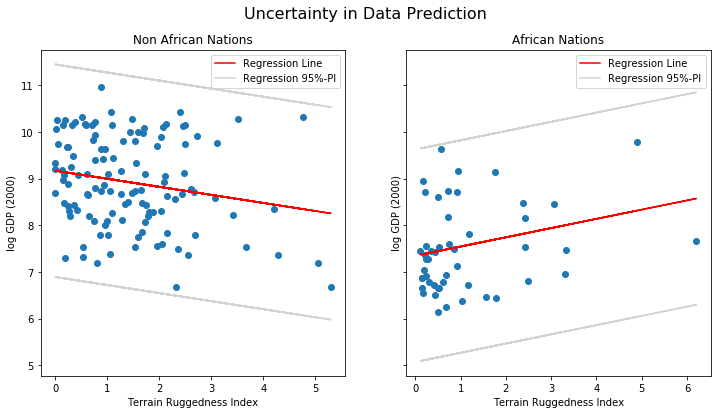

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Uncertainty in Data Prediction", fontsize=16)
ax[0].scatter(x_data[x_data[:,0]==0,1].detach().numpy(), y_data[x_data[:,0]==0].detach().numpy())
ax[1].scatter(x_data[x_data[:,0]==1,1].detach().numpy(), y_data[x_data[:,0]==1].detach().numpy())

ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regressionLineMean(x_data[x_data[:,0]==0,:],guide).detach().numpy(), color='r', label = 'Regression Line')
ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regressionLineMeanCI(x_data[x_data[:,0]==0,:],guide)[0].detach().numpy(), color='lightgrey', label = 'Regression 95%-PI')
ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regressionLineMeanCI(x_data[x_data[:,0]==0,:],guide)[1].detach().numpy(), color='lightgrey')
ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regressionLineMean(x_data[x_data[:,0]==1,:],guide).detach().numpy(), color='r', label = 'Regression Line')
ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regressionLineMeanCI(x_data[x_data[:,0]==1,:],guide)[0].detach().numpy(), color='lightgrey', label = 'Regression 95%-PI')
ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regressionLineMeanCI(x_data[x_data[:,0]==1,:],guide)[1].detach().numpy(), color='lightgrey')


ax[0].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="Non African Nations")
ax[1].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="African Nations")

ax[0].legend()
ax[1].legend()
plt.show()



Look like all the data points fall inside the estimated confidence intervals, being able to capture the uncertaintity in our predictions. 

## 2.5 Model Evaluation II: Model's Uncertainty
In this case, we'll sample different the regression lines to see how using a Bayesian approach we are able to capture the model undertainty.

In [16]:
def regressionLineSample(x_data,guide):
    return (guide()['b'] + torch.mm(x_data,torch.t(guide()['w']))).squeeze(-1)

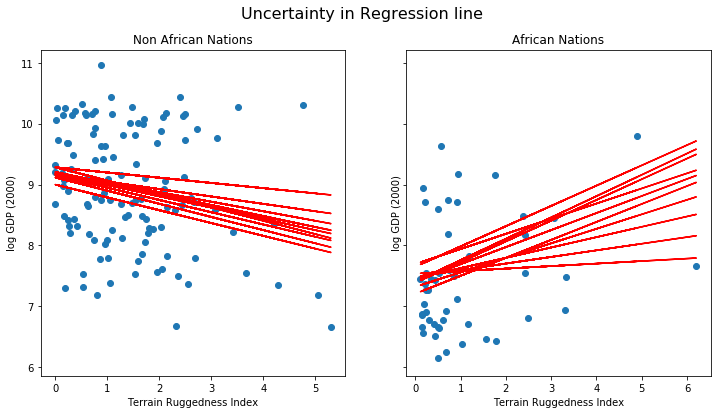

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Uncertainty in Regression line ", fontsize=16)
ax[0].scatter(x_data[x_data[:,0]==0,1].detach().numpy(), y_data[x_data[:,0]==0].detach().numpy())
ax[1].scatter(x_data[x_data[:,0]==1,1].detach().numpy(), y_data[x_data[:,0]==1].detach().numpy())

for i in range(10):
    ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regressionLineSample(x_data[x_data[:,0]==0,:],guide).detach().numpy(), color='r')
    ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regressionLineSample(x_data[x_data[:,0]==1,:],guide).detach().numpy(), color='r')

ax[0].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="Non African Nations")
ax[1].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="African Nations")

plt.show()

The above figure shows the uncertainty in our estimate of the regression line. Note that for lower values of ruggedness there are many more data points, and as such, the regression lines are less uncertainty than in high ruggness values, where there is much more uncertainty, specially in the case of African nations. 

## 2.6 Model Evaluation III: Combining uncertainties

Finally we can combine uncertainties in the model with uncertainties in the predictions, given rise to a more accurate modelling of the data.

In [18]:
def regressionLineSampleCI(x_data,guide):
    return [(guide()['b'] + torch.mm(x_data,torch.t(guide()['w']))).squeeze(-1) -2/torch.sqrt(guide()['precision']), 
            (guide()['b'] + torch.mm(x_data,torch.t(guide()['w']))).squeeze(-1) +2/torch.sqrt(guide()['precision'])]
            

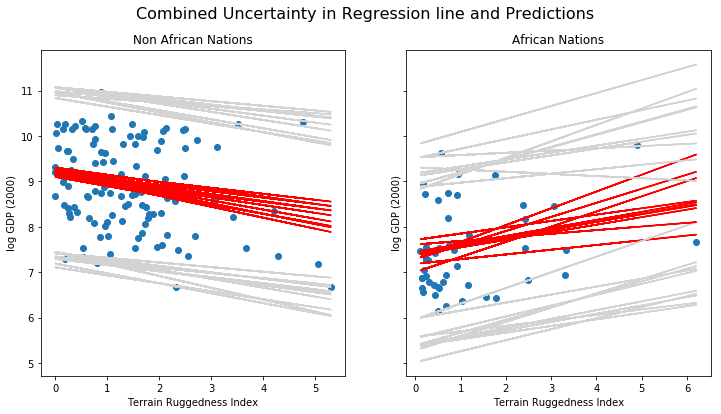

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Combined Uncertainty in Regression line and Predictions", fontsize=16)
ax[0].scatter(x_data[x_data[:,0]==0,1].detach().numpy(), y_data[x_data[:,0]==0].detach().numpy())
ax[1].scatter(x_data[x_data[:,0]==1,1].detach().numpy(), y_data[x_data[:,0]==1].detach().numpy())

for i in range(10):
    ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regressionLineSample(x_data[x_data[:,0]==0,:],guide).detach().numpy(), color='r')
    ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regressionLineSampleCI(x_data[x_data[:,0]==0,:],guide)[0].detach().numpy(), color='lightgrey')
    ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regressionLineSampleCI(x_data[x_data[:,0]==0,:],guide)[1].detach().numpy(), color='lightgrey')
    ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regressionLineSample(x_data[x_data[:,0]==1,:],guide).detach().numpy(), color='r')
    ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regressionLineSampleCI(x_data[x_data[:,0]==1,:],guide)[0].detach().numpy(), color='lightgrey')
    ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regressionLineSampleCI(x_data[x_data[:,0]==1,:],guide)[1].detach().numpy(), color='lightgrey')


ax[0].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="Non African Nations")
ax[1].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="African Nations")

plt.show()

## 2.7 The relationship between ruggedness and log GPD

Finally, we go back to the previous analysis about the relationship between ruggedness and log GPD. Now, we can compute uncertaintis obver this relationship. As can be seen, this relationship is negative for Non African Nations with high probability, and positive for African nations in most of the cases. In fact, there is non-negligible probability that this is relationship is also negative. This is the consequence of the low number of samples in the case of African nations.

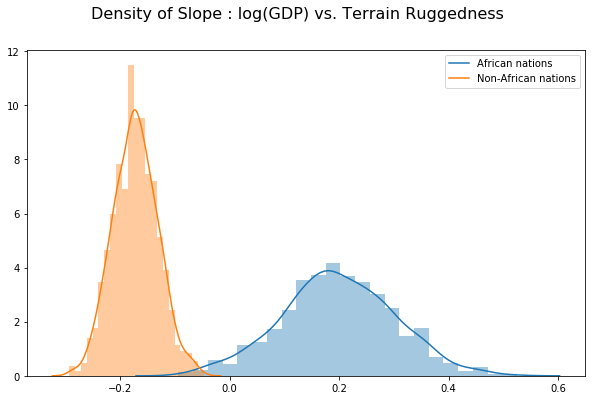

In [20]:
weight = torch.stack([guide()['w'] for i in range(1000)]).squeeze()
gamma_within_africa = weight[:,1] + weight[:,2]
gamma_outside_africa = weight[:,1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa.detach().numpy(), kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa.detach().numpy(), kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)
plt.show()

# <span style="color:red">Exercise</span> 

Build a Bayesian logistic regression for predicting african vs non-african countries based on ruggedness index and log GDP. 

### Data

In [21]:
# Display first 10 entries 
display(df[0:10])

,cont_africa,rugged,african_rugged,rgdppc_2000
2,1,0.858,0.858,7.492609
4,0,3.427,0.000,8.216929
7,0,0.769,0.000,9.933263
8,0,0.775,0.000,9.407032
9,0,2.688,0.000,7.792343
11,0,0.006,0.000,9.212541
12,0,0.143,0.000,10.143191
13,0,3.513,0.000,10.274632
14,0,1.672,0.000,7.852028
15,1,1.780,1.780,6.432380


In [22]:
x_data, y_data = data[:, (1,3)], data[:, 0]

### Model

In [23]:
def model(x_data, y_data):
    # weight and bias priors

    with pyro.plate("map", len(x_data)):
        # Compute logits as a linear combination between data and weights. 

        # Define a Binomial distribution as the observed value 


### Inference

In [24]:
optim = Adam({"lr": 0.1})
guide = AutoDiagonalNormal(model)
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=10)
train(x_data, y_data)

[iteration 0001] loss: 1.8738
[iteration 0501] loss: 0.5532
[iteration 1001] loss: 0.5008
[iteration 1501] loss: 0.5000
[iteration 2001] loss: 0.5232
[iteration 2501] loss: 0.4976
[iteration 3001] loss: 0.4927
[iteration 3501] loss: 0.5203
[iteration 4001] loss: 0.5196
[iteration 4501] loss: 0.4797


In [25]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([-0.3359, -1.4938, 11.7846], requires_grad=True)
auto_scale tensor([0.1347, 0.0209, 0.1623], grad_fn=<AddBackward0>)


### Model Evaluation I

In [26]:
def logisticRegressionLineMean(x_data,guide):
    return (pyro.param('auto_loc')[2] + torch.mm(x_data,torch.t(pyro.param('auto_loc')[0:2].reshape(1,2)))).squeeze(-1)

def logisticRegressionPredictions(x_data,guide):
    logits = logisticRegressionLineMean(x_data,guide)
    return Binomial(logits = logits).mean

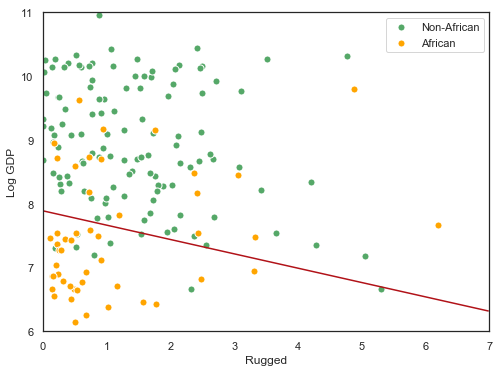

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
xx, yy = np.mgrid[0:7:.01, 6:11:.01]
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
probs = logisticRegressionPredictions(grid,guide).reshape(xx.shape).detach().numpy()

f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Reds", vmin=0, vmax=.6)

ax.scatter(x_data[y_data==0,0], x_data[y_data==0, 1], c='g', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='Non-African')

ax.scatter(x_data[y_data==1,0], x_data[y_data==1, 1], c='orange', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='African')


ax.set(aspect="equal",
       xlim=(0, 7), ylim=(6, 11),
       xlabel="Rugged", ylabel="Log GDP")
ax.legend()

### Model Evaluation II

In [28]:
def logisticRegressionLineSample(x_data,guide):
    return (guide()['b'] + torch.mm(x_data,torch.t(guide()['w']))).squeeze(-1)

def logisticRegressionPredictionsSample(x_data,guide):
    logits = logisticRegressionLineSample(x_data,guide)
    return Binomial(logits = logits).mean

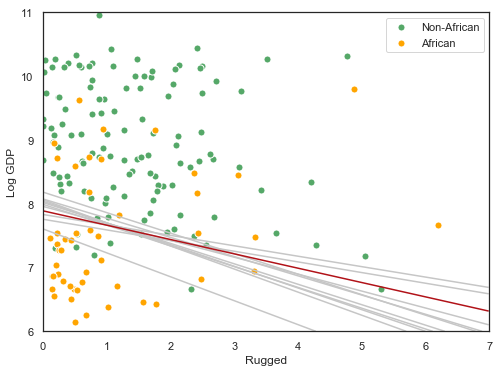

In [29]:
sns.set(style="white")
xx, yy = np.mgrid[0:7:.01, 6:11:.01]
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

f, ax = plt.subplots(figsize=(8, 6))



for i in range(10):
    probs = logisticRegressionPredictionsSample(grid,guide).reshape(xx.shape).detach().numpy()
    ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=1.5)

probs = logisticRegressionPredictions(grid,guide).reshape(xx.shape).detach().numpy()
ax.contour(xx, yy, probs, levels=[.5], cmap="Reds", vmin=0, vmax=.6)


ax.scatter(x_data[y_data==0,0], x_data[y_data==0, 1], c='g', s=50,
           cmap="Greens", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='Non-African')

ax.scatter(x_data[y_data==1,0], x_data[y_data==1, 1], c='orange', s=50,
           cmap="Oranges", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='African')


ax.set(aspect="equal",
       xlim=(0, 7), ylim=(6, 11),
       xlabel="Rugged", ylabel="Log GDP")
ax.legend()

### References
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012